### Initialization Bock

In [1]:
#!pip install tensorflow==1.12.0

In [2]:
# Initialization
colab_run=False
anc_box= False
_grid_offset=True
train=True
if colab_run==True:
  !pip install pydrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  import os, cv2
  from google.colab import drive
  drive.mount('/content/drive/')

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import concatenate
from matplotlib import pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
import pickle
import os, cv2

#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

# %matplotlib inline


C:\Users\irfan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\irfan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\irfan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\irfan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dty

### Configure Block

### Model Building Block

In [3]:
LABELS=['person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep','aeroplane', 'bicycle',
         'boat', 'bus', 'car', 'motorbike', 'train', 'bottle', 'chair','dining table',
         'potted plant', 'sofa', 'tvmonitor']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13 
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
#ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
ANCHORS          = [ 4.469053,2.148582,10.548851,5.381520,11.420664,9.961033,6.517299,3.699693,2.469196,1.599054]
#ANCHORS=[13,13]
NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 10
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50


In [4]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

def build_model():
  input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
  true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

  # Layer 1
  x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
  x = BatchNormalization(name='norm_1')(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Layer 2
  x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
  x = BatchNormalization(name='norm_2')(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Layer 3
  x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
  x = BatchNormalization(name='norm_3')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 4
  x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
  x = BatchNormalization(name='norm_4')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 5
  x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
  x = BatchNormalization(name='norm_5')(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Layer 6
  x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
  x = BatchNormalization(name='norm_6')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 7
  x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
  x = BatchNormalization(name='norm_7')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 8
  x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
  x = BatchNormalization(name='norm_8')(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Layer 9
  x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
  x = BatchNormalization(name='norm_9')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 10
  x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
  x = BatchNormalization(name='norm_10')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 11
  x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
  x = BatchNormalization(name='norm_11')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 12
  x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
  x = BatchNormalization(name='norm_12')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 13
  x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
  x = BatchNormalization(name='norm_13')(x)
  x = LeakyReLU(alpha=0.1)(x)

  skip_connection = x

  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Layer 14
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
  x = BatchNormalization(name='norm_14')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 15
  x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
  x = BatchNormalization(name='norm_15')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 16
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
  x = BatchNormalization(name='norm_16')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 17
  x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
  x = BatchNormalization(name='norm_17')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 18
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
  x = BatchNormalization(name='norm_18')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 19
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
  x = BatchNormalization(name='norm_19')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 20
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
  x = BatchNormalization(name='norm_20')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 21
  skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
  skip_connection = BatchNormalization(name='norm_21')(skip_connection)
  skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
  skip_connection = Lambda(space_to_depth_x2)(skip_connection)

  x = concatenate([skip_connection, x])

  # Layer 22
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
  x = BatchNormalization(name='norm_22')(x)
  x = LeakyReLU(alpha=0.1)(x)

  if anc_box==True:
    # Layer 23
    x = Conv2D(BOX*(4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W,BOX,4 + 1 + CLASS))(x)
  else :
    # Layer 23
    x = Conv2D((4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W,4 + 1 + CLASS))(x)

  # small hack to allow true_boxes to be registered when Keras build the model 
  # for more information: https://github.com/fchollet/keras/issues/2790
  #output = Lambda(lambda args: args[0])([output, true_boxes])#Change :Hasib

  #model = Model([input_image, true_boxes], output)#Change :Hasib
  model = Model(input_image, output)
  return model
  #model.load_weights('/content/drive/My Drive/Data/yolo_net_ep500_act.h5')


class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4

def load_weights(model,path_wst):
  wt_path = path_wts                      
  weight_reader = WeightReader(wt_path)
  weight_reader.reset()
  nb_conv = 23

  for i in range(1, nb_conv+1):
      conv_layer = model.get_layer('conv_' + str(i))

      if i < nb_conv:
          norm_layer = model.get_layer('norm_' + str(i))

          size = np.prod(norm_layer.get_weights()[0].shape)

          beta  = weight_reader.read_bytes(size)
          gamma = weight_reader.read_bytes(size)
          mean  = weight_reader.read_bytes(size)
          var   = weight_reader.read_bytes(size)

          weights = norm_layer.set_weights([gamma, beta, mean, var])       

      if len(conv_layer.get_weights()) > 1:
          bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
          kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
          kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
          kernel = kernel.transpose([2,3,1,0])
          conv_layer.set_weights([kernel, bias])
      else:
          kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
          kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
          kernel = kernel.transpose([2,3,1,0])
          conv_layer.set_weights([kernel])
  return model



def yolo_loss_1(y_true, y_pred):
      loss=0
          ### adjust w and h
      ob_mask= tf.expand_dims(y_true[..., 4], axis=-1)
      conf_mask=y_true[...,4]
      
      if anc_box==True:
        _x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))#1,13,13,1,1
        _y = tf.transpose(_x, (0,2,1,3,4))#1,13,13,1,1
        _grid = tf.tile(tf.concat([_x,_y], -1), [BATCH_SIZE, 1, 1, 5, 1])#10,13,13,5,1

        pred_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
        pred_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
        
      if anc_box==False and _grid_offset==True:
        _x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1)))#1,13,13,1,1
        _y = tf.transpose(_x, (0,2,1,3))#1,13,13,1
        _grid = tf.tile(tf.concat([_x,_y], -1), [BATCH_SIZE, 1, 1, 1])#10,13,13,1

        pred_xy = tf.sigmoid(y_pred[..., :2]) + _grid
        pred_wh = y_pred[..., 2:4]# * np.reshape(ANCHORS, [1,1,1,BOX,2])
        #pred_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
      
      if _grid_offset==False:
        pred_xy=y_pred[...,0:2] #+ cell_grid # if cell_grid Batch_Gen center_x -=grid_x
        pred_wh=y_pred[...,2:4]
      

      true_xy=y_true[...,0:2]
      true_wh=y_true[...,2:4]
      pred_conf=y_pred[...,4]
      ### adjust confidence
      true_wh_half = true_wh / 2.
      true_mins    = tf.subtract(true_xy,true_wh_half)
      true_maxes   = tf.add(true_xy,true_wh_half)
    
      pred_wh_half = pred_wh / 2.
      pred_mins    = tf.subtract(pred_xy,pred_wh_half)
      pred_maxes   = tf.add(pred_xy,pred_wh_half)       
    
      intersect_mins  = tf.maximum(pred_mins,  true_mins)
      intersect_maxes = tf.minimum(pred_maxes, true_maxes)
      intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
      intersect_areas = tf.multiply(intersect_wh[..., 0] , intersect_wh[..., 1])
    
      true_areas = tf.multiply(true_wh[..., 0] , true_wh[..., 1])
      pred_areas = tf.multiply(pred_wh[..., 0] , pred_wh[..., 1])

      union_areas =tf.subtract(tf.add(pred_areas,true_areas),intersect_areas)
      intersect_areas=tf.add(intersect_areas,1)
      union_areas=tf.add(union_areas,1)
      iou_scores  = tf.truediv(intersect_areas, union_areas)
      true_box_class = tf.argmax(y_true[..., 5:], -1)
      pred_box_class=y_pred[..., 4]
      pred_box_class = y_pred[..., 5:]
      class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class)
    
      #class_mask = y_true[..., 4] * tf.to_float(true_box_class)
      nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
      true_conf =tf.multiply( iou_scores,y_true[..., 4])
      
      loss_bb=tf.subtract(true_xy,pred_xy)
      loss_bb=tf.square(loss_bb)
      loss_bb=tf.multiply(loss_bb,ob_mask)
      loss_bb=tf.reduce_sum(loss_bb)
      loss_wh=tf.subtract((true_wh),(pred_wh))
      loss_wh=tf.square(loss_wh)
      loss_wh=tf.multiply(loss_wh,ob_mask)
      loss_wh=tf.reduce_sum(loss_wh)
      loss_conf=tf.subtract(true_conf,pred_conf)
      loss_conf=tf.square(loss_conf)
      loss_conf=tf.multiply(loss_conf,conf_mask)
      loss_conf=tf.reduce_sum(loss_conf)
      loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
      loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
      loss=loss_bb+loss_wh+loss_conf+loss_class       
      return loss


### Data Ready Block

In [5]:
if colab_run==True :data_dir='/content/drive/My Drive/CNN_Basic/'
else: data_dir=''
from xml.etree import ElementTree as ET

def read_content(xml_file: str):
    objs=[]
    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    filename = root.find('filename').text
    size=root.find('size')
    img_h=int(size.find('height').text)
    img_w=int(size.find('width').text)
    print(img_h)
    for boxes in root.iter('object'):
        
        name = boxes.find('name').text
        ymin, xmin, ymax, xmax = None, None, None, None
        
        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)
        wf=IMAGE_W/img_w
        hf=IMAGE_H/img_h
        obj={'name':name,
          'xmin':xmin*wf,
          'ymin':ymin*hf,
          'xmax':xmax*wf,
          'ymax':ymax*hf}
        objs.append(obj)
        
    out={
          'filename':data_dir+'VOC_Images/'+filename,
          'height':img_h,
          'width':img_w,
          'object':objs
    }
        
    return filename, list_with_all_boxes,out

def IOU(bboxes1, bboxes2):
        #import pdb;pdb.set_trace()
        x1_min, y1_min, x1_max, y1_max = list(bboxes1)
        x2_min, y2_min, x2_max, y2_max = list(bboxes2)
        xA = np.maximum(x1_min, x2_min)
        yA = np.maximum(y1_min, y2_min)
        xB = np.minimum(x1_max, x2_max)
        yB = np.minimum(y1_max, y2_max)
        interArea = np.maximum((xB - xA ), 0) * np.maximum((yB - yA ), 0)
        boxAArea = (x1_max - x1_min ) * (y1_max - y1_min )
        boxBArea = (x2_max - x2_min ) * (y2_max - y2_min )
        iou = interArea / (boxAArea + boxBArea - interArea)
        return iou
    
def Batch_Gen(all_data,no_of_batch):
      while(True):
            N=len(all_data)
            _batch_size=N//no_of_batch

            for _ind in range(no_of_batch):

                batch=all_data[_ind*_batch_size:(_ind+1)*_batch_size]
                n=len(batch)
                x_batch = np.zeros((n,IMAGE_H, IMAGE_W,3),dtype=np.float32)                         # input images
                if anc_box==True:
                  y_batch = np.zeros((n, GRID_H, GRID_W,BOX,4+1+len(LABELS)),dtype=np.float)                # desired network output
                else :
                  y_batch = np.zeros((n, GRID_H, GRID_W,4+1+len(LABELS)),dtype=np.float)                # desired network output
                instance_count=0

                
                for sample in batch:

                        image_name = sample['filename']
                        img = cv2.imread(image_name)
                        img = cv2.resize(img, (IMAGE_H,IMAGE_W))
                        img = img[:,:,::-1]
                        img_w=sample['height']
                        img_h=sample['width']
                        all_objs = sample['object']
                        # construct output from object's x, y, w, h
                        true_box_index = 0
                        anchors = [[0, 0, ANCHORS[2*i], ANCHORS[2*i+1]] for i in range(int(len(ANCHORS)//2))]
                        for obj in all_objs:
                            no_gridx=float(IMAGE_W / GRID_W)
                            no_gridy=float(IMAGE_H /GRID_H)
                            if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in LABELS:
                                center_x = .5*(obj['xmin'] + obj['xmax'])
                                center_x = center_x/no_gridx
                                center_y = .5*(obj['ymin'] + obj['ymax'])
                                center_y=center_y/no_gridy
                                grid_x = int(np.floor(center_x))
                                grid_y = int(np.floor(center_y))
                                if _grid_offset==False:
                                            center_x-=grid_x
                                            center_y-=grid_y
                                #center_x-=grid_x
                                #center_y-=grid_y
                                if grid_x < GRID_W and grid_y < GRID_H:
                                    obj_indx  = LABELS.index(obj['name'])
                                    center_w = (obj['xmax'] - obj['xmin'])/no_gridx #/ (float(self.config['IMAGE_W'])# / self.config['GRID_W']) # unit: grid cell
                                    center_h = (obj['ymax'] - obj['ymin'])/no_gridy #/ (float(self.config['IMAGE_H'])# / self.config['GRID_H']) # unit: grid cell
                                    center_w=center_w
                                    center_h=center_h

                                    box = [center_x, center_y, center_w, center_h]

                                    # find the anchor that best predicts this box#Change :Hasib
                                    best_anchor = -1
                                    max_iou     = -1

                                    shifted_box = [0, 0, center_w, center_h]

                                    for i in range(len(anchors)):
                                        anchor = anchors[i]
                                        iou    = IOU(shifted_box, anchor)

                                        if max_iou < iou:
                                            best_anchor = i
                                            max_iou     = iou

                                    # assign ground truth x, y, w, h, confidence and class probs to y_batch
                                    if anc_box==True:
                                      y_batch[instance_count, grid_y, grid_x, best_anchor,0:4] = box
                                      y_batch[instance_count, grid_y, grid_x, best_anchor,4  ] = 1.
                                      y_batch[instance_count, grid_y, grid_x, best_anchor,5+obj_indx] = 1
                                    else :
                                      y_batch[instance_count, grid_y, grid_x,0:4] = box
                                      y_batch[instance_count, grid_y, grid_x,4  ] = 1.
                                      y_batch[instance_count, grid_y, grid_x,5+obj_indx] = 1

                                    # assign the true box to b_batch
                                    #b_batch[instance_count, 0, 0, 0, true_box_index] = box#Change: Hasib

                                    #true_box_index += 1
                                    #true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']

                        # assign input image to x_batch
                        x_batch[instance_count] = img/255

                        # increase instance counter in current batch
                        instance_count += 1  

                        #print(' new batch created', idx)
                yield (x_batch, y_batch)




### Reading Data

In [6]:
import glob
import cv2
import pandas as pd
import pickle

save=False
if save==True:
  fnames=[]
  all_data=[]
  i=0
  
  for file in glob.glob(data_dir+'Annotations/*'):
    i+=1
    print(i)
    _,_,obj=read_content(file)
    #fname, boxes, objs = read_content(file)
    #fnames.append(fname)
    all_data.append(obj)
    
  f=open(data_dir+'_VOC_dfs','wb')
  pickle.dump(all_data,f)
  f.close()

f=open(data_dir+'_VOC_dfs','rb')
all_data=pickle.load(f)
f.close()

In [7]:
import numpy as np

N=len(all_data)
n_train=int(N*0.8)
n_valid=int(N*0.2)
N,n_train,n_valid
if train==True or train==False:
  
  train_imgs=all_data[:n_train]
  valid_imgs=all_data[n_train:]
  train_batch=[]
  valid_batch=[]
  no_of_tr_batch=int(np.floor(n_train/BATCH_SIZE))
  train_batch=Batch_Gen(train_imgs,no_of_tr_batch)
  no_of_val_batch=int(np.floor(n_valid/BATCH_SIZE))
  valid_batch=Batch_Gen(valid_imgs,no_of_val_batch)

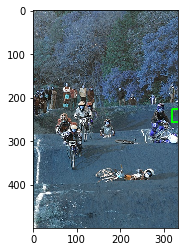

In [102]:
img=cv2.imread(valid_imgs[1]['filename'])
xmin,ymin,xmax,ymax=list(valid_imgs[1]['object'][-1].values())[1:]
cv2.rectangle(img, (int(xmin),int(ymin)), (int(xmax),int(ymax)), (0,255,0), 3)
plt.imshow(img)

In [96]:
valid_imgs[1]#['object']

{'filename': 'VOC_Images/007953.jpg',
 'height': 500,
 'width': 333,
 'object': [{'name': 'person',
   'xmin': 389.76576576576576,
   'ymin': 138.944,
   'xmax': 408.5045045045045,
   'ymax': 178.048},
  {'name': 'person',
   'xmin': 322.30630630630634,
   'ymin': 159.744,
   'xmax': 354.7867867867868,
   'ymax': 180.54399999999998},
  {'name': 'person',
   'xmin': 274.83483483483485,
   'ymin': 160.576,
   'xmax': 299.8198198198198,
   'ymax': 183.04},
  {'name': 'person',
   'xmin': 241.1051051051051,
   'ymin': 146.432,
   'xmax': 266.0900900900901,
   'ymax': 183.04},
  {'name': 'person',
   'xmin': 131.17117117117118,
   'ymin': 142.272,
   'xmax': 157.40540540540542,
   'ymax': 183.87199999999999},
  {'name': 'person',
   'xmin': 156.15615615615616,
   'ymin': 148.096,
   'xmax': 178.64264264264264,
   'ymax': 185.536},
  {'name': 'person',
   'xmin': 107.43543543543544,
   'ymin': 144.768,
   'xmax': 129.92192192192192,
   'ymax': 188.03199999999998},
  {'name': 'person',
   'xm

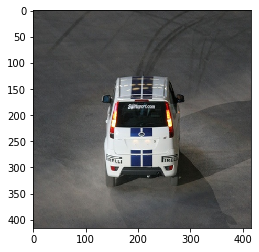

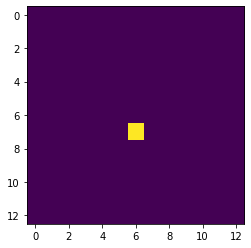

index 4


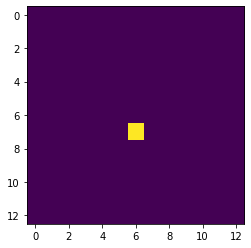

In [8]:
data_check=True
if data_check==True:
    sampleX,sampleY=next(train_batch)
    plt.imshow(sampleX[3])
    plt.show()
    img=sampleY[3][...,11+5]
    plt.imshow(img)
    plt.show()
    for i in range(4,5):
        print('index',i)
        plt.imshow(sampleY[3][...,i]*10)
        plt.show()

### Train Block

In [9]:
lr=1e-5
epochs=24
optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)


model=build_model()
#model.summary()

In [10]:
root='D:/'
path_wts=root+'yolo.weights'
path_wts_final=root+'yolo_400.h5'

def train_model(model):
  
  model.compile(loss=yolo_loss_1, optimizer=optimizer,metrics=['accuracy'])
  if anc_box==True:
    model.compile(loss=custom_loss, optimizer=optimizer,metrics=['accuracy'])
  history=model.fit_generator(train_batch,steps_per_epoch=no_of_tr_batch,epochs=epochs,validation_data=valid_batch,validation_steps=no_of_val_batch)

  plt.plot(history.history['acc'])
  plt.plot(history.history['loss'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
    

  #f=open(data_dir+'history:_ep_24_v-1.0','wb')
  #pickle.dump(history,f)
  #f.close()
  return model,history


Epoch 1/24
400/400 [==============================] - 56s 141ms/step - loss: 1009.1962 - acc: 0.0704 - val_loss: 327.3168 - val_acc: 0.0806
Epoch 2/24
400/400 [==============================] - 53s 133ms/step - loss: 244.0282 - acc: 0.0495 - val_loss: 217.2290 - val_acc: 0.0643
Epoch 3/24
400/400 [==============================] - 54s 134ms/step - loss: 172.0019 - acc: 0.0447 - val_loss: 173.1192 - val_acc: 0.0579
Epoch 4/24
400/400 [==============================] - 54s 134ms/step - loss: 139.7922 - acc: 0.0424 - val_loss: 148.0596 - val_acc: 0.0546
Epoch 5/24
400/400 [==============================] - 55s 136ms/step - loss: 119.3307 - acc: 0.0403 - val_loss: 132.2766 - val_acc: 0.0496
Epoch 6/24
400/400 [==============================] - 56s 139ms/step - loss: 104.7302 - acc: 0.0369 - val_loss: 121.5341 - val_acc: 0.0442
Epoch 7/24
400/400 [==============================] - 57s 143ms/step - loss: 93.4920 - acc: 0.0325 - val_loss: 113.7318 - val_acc: 0.0379
Epoch 8/24
400/400 [=======

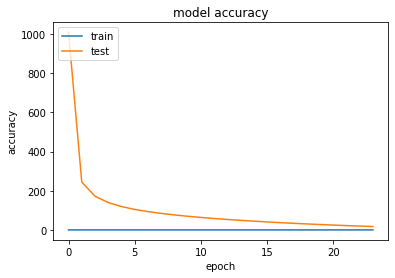

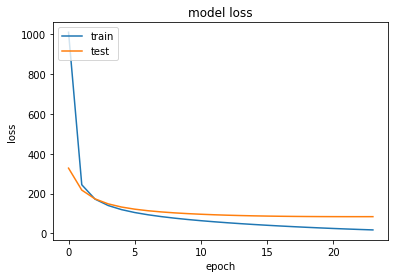

In [11]:
if train==True:
    model=load_weights(model,path_wts)
    for layer in model.layers[:-5]:
        layer.trainable=False
    model,history=train_model(model)
if train==False:
    model.load_weights(path_wts_final)

### Predicion Block

0.0
0.02405469115750327
0.0


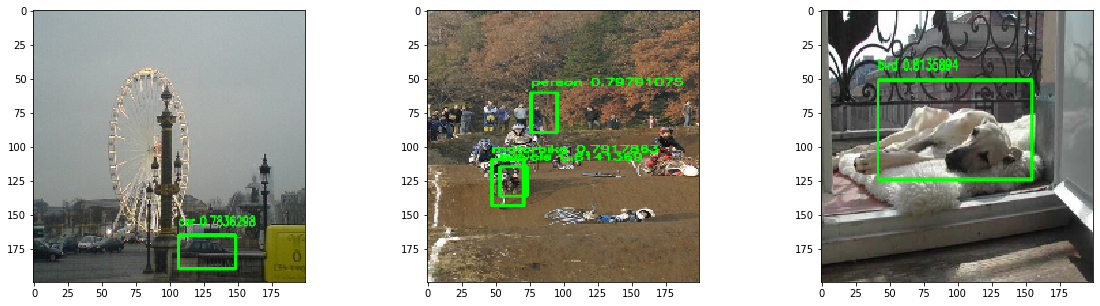

0.0
0.6795370829843168
0.4092880530133988


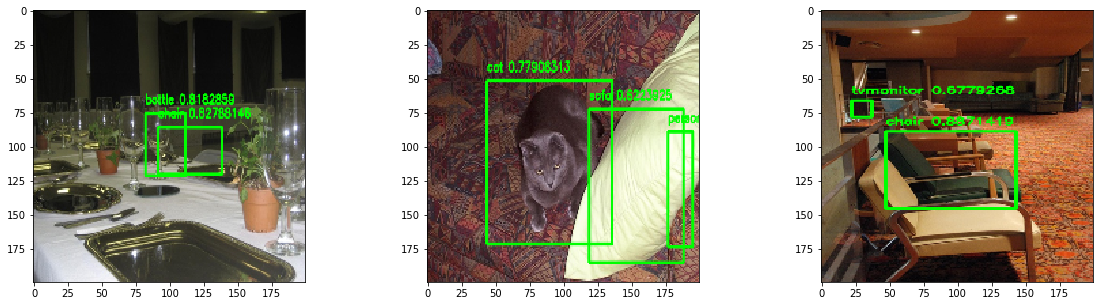

0.5658416717197332
0.16774387700316654
0.6607323291859102


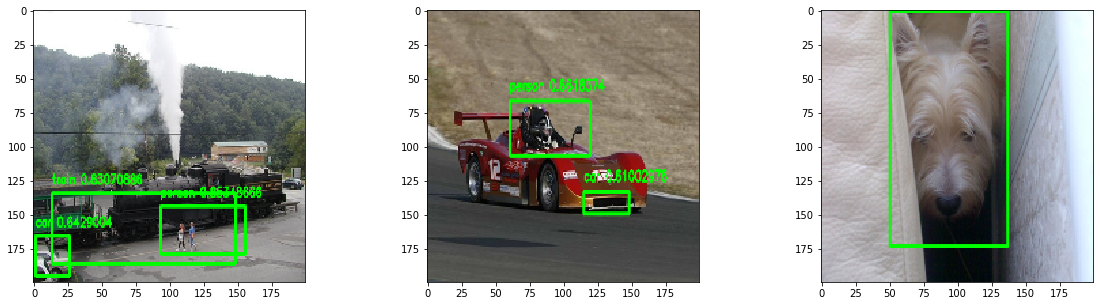

0.053007624156897956
0.3625298647474466
0.5857631743418855


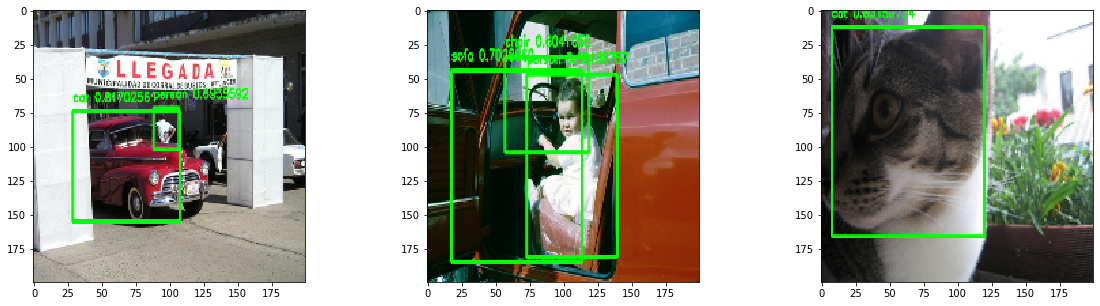

0.0
0.0
0.0


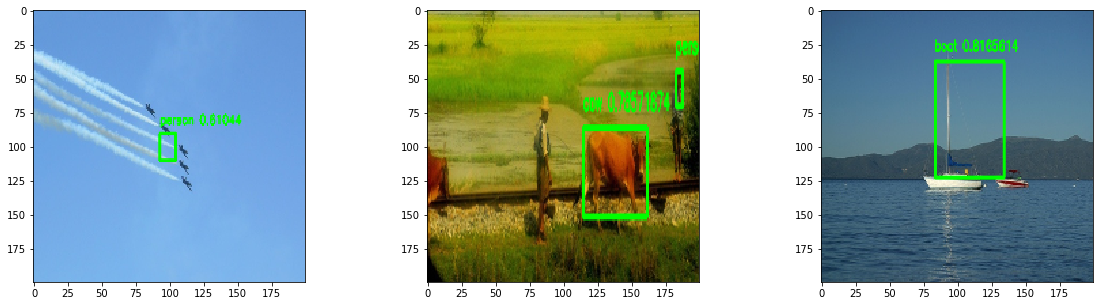

0.0
0.3049803129171193
0.6317950094683249


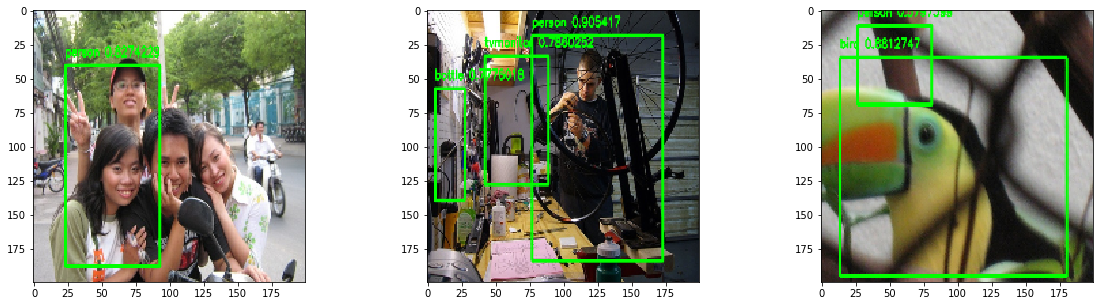

0.3925414333010439
0.0
0.0


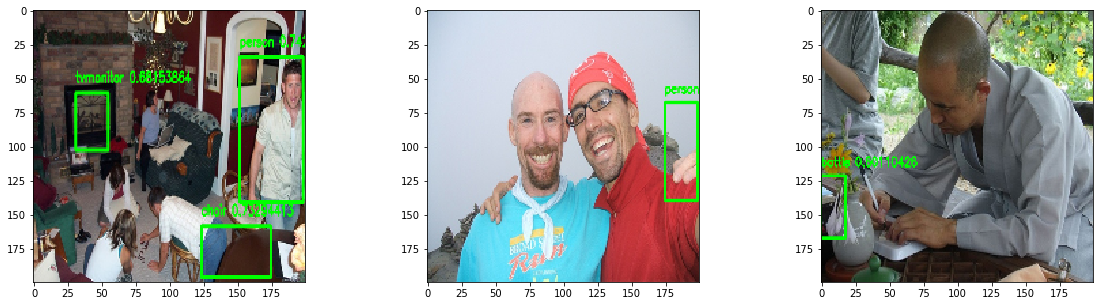

0.43902799942153187
0.558276109766051
0.34836847607462157


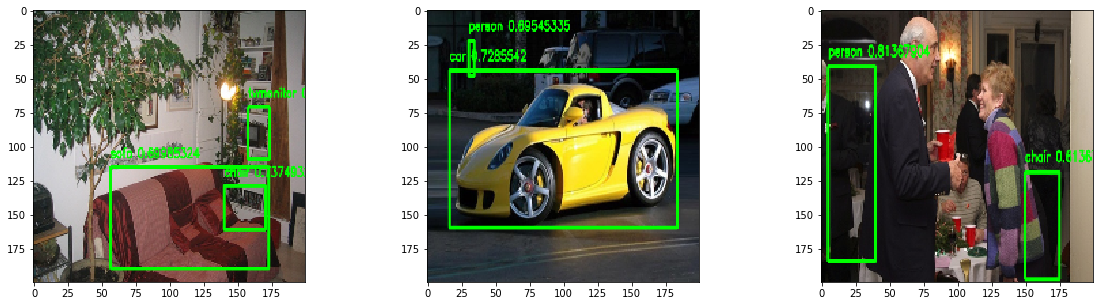

0.0
0.4779995710268073
0.2751336316711554


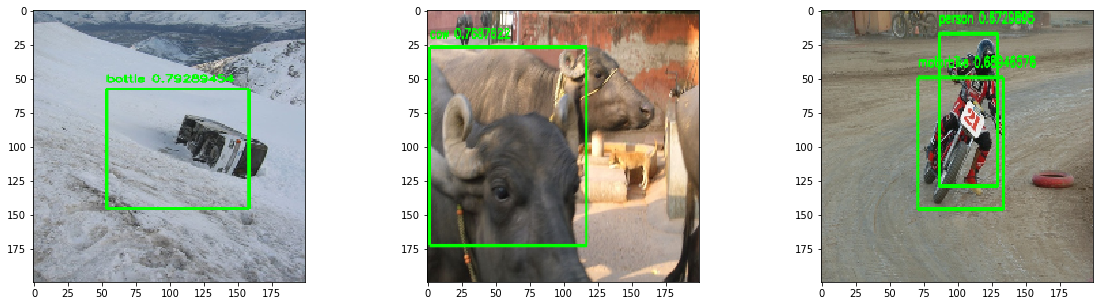

0.5819213321085152
0.0
0.39593161319322145


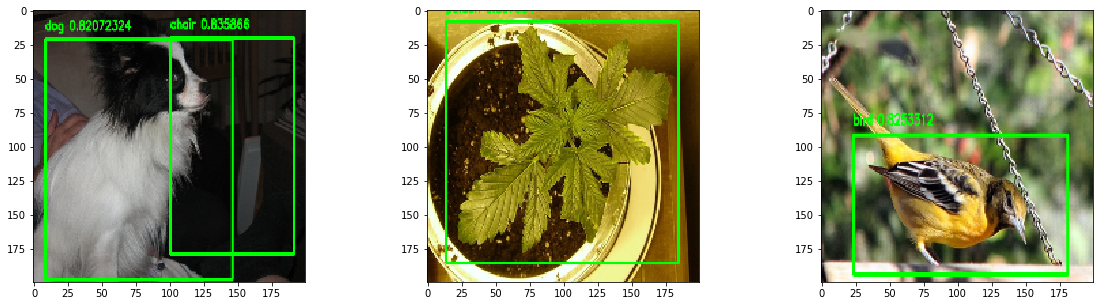

0.5629184208488123
0.9912129898206548
0.8642571303504638


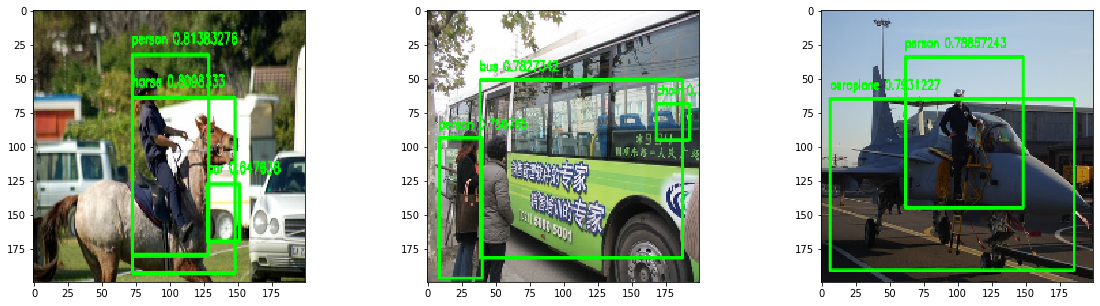

0.5474737760143339
0
0.521142943272148


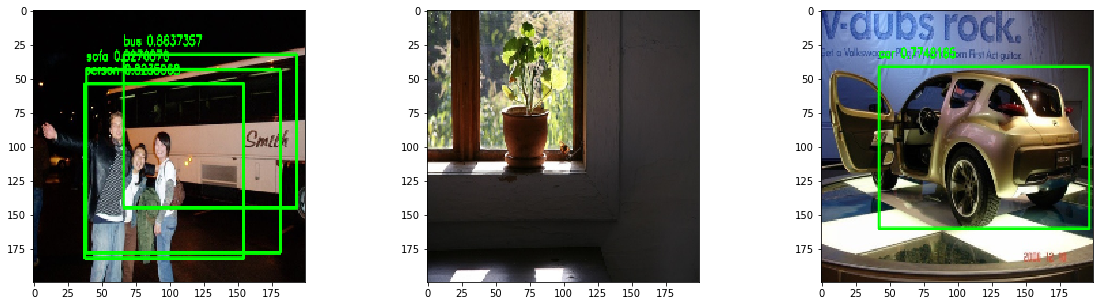

0.5000207202118838
0.5184183779168903
0.45117145305921946


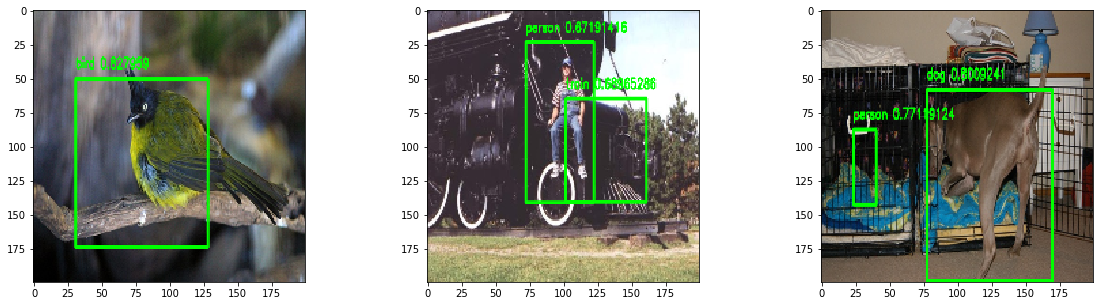

0.4880092915290107
0.5765553479573897
1.0692818343020123


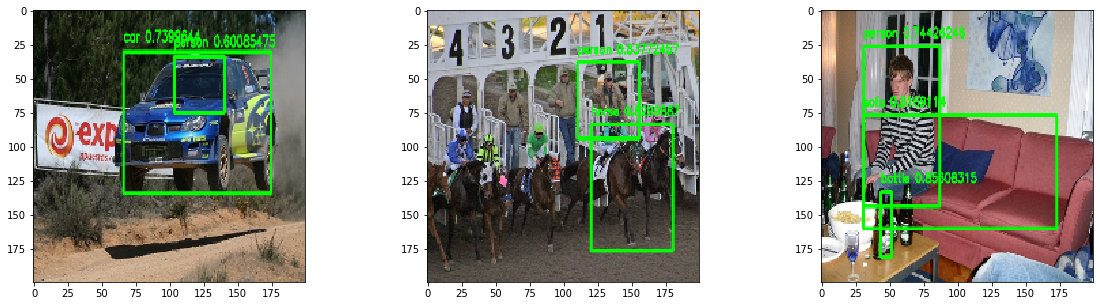

0.43562482515426676
0.0
0.0


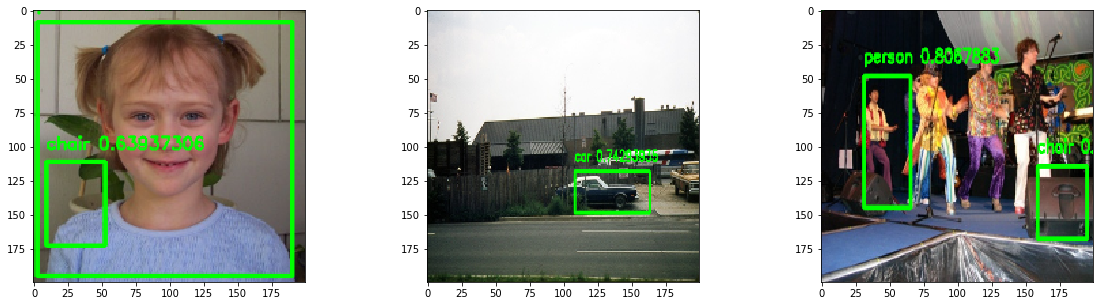

0.5053488618965536
0.3060669898548748
0.18558230183082866


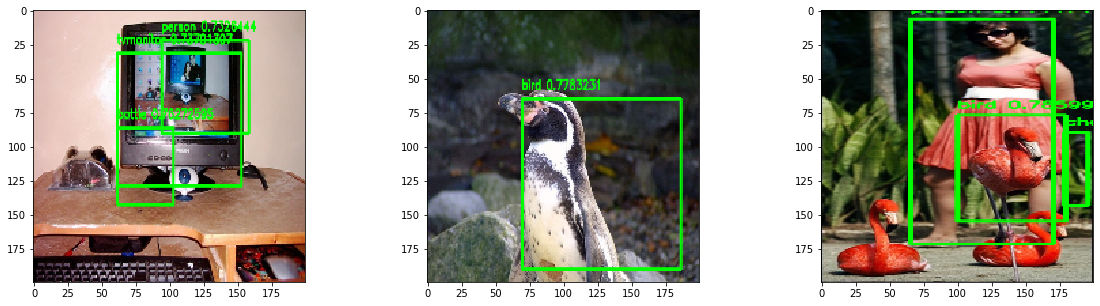

0.38917430145241627
0.7207307284354609
mean error 0.0


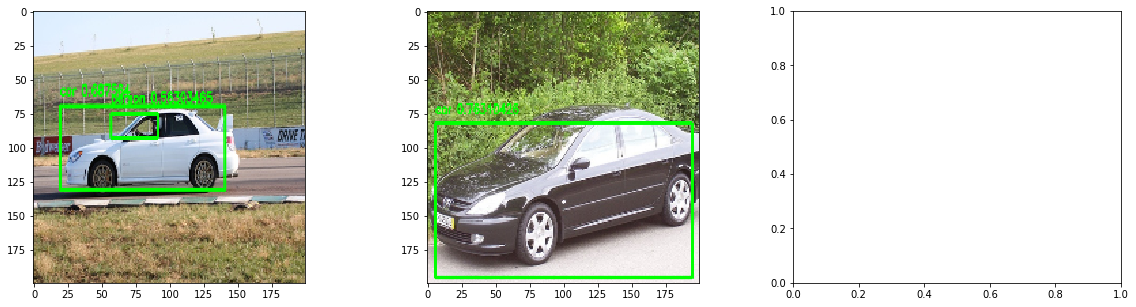

In [93]:
def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_netout_anc(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
    #grid_h, grid_w, nb_box = netout.shape[:3]
    grid_h, grid_w = netout.shape[:2]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
                #classes = netout[row,col,5:]
                confidence = netout[row,col,b,4]
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    #x, y, w, h = netout[row,col,b,:4]
                    x, y, w, h = netout[row,col,b,:4]
                    #print(col,_sigmoid(x-col),row,_sigmoid(y),w,h)
                    x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                    w = ANCHORS[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = ANCHORS[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    #print(x,y,w,h)
                    classes=np.argmax(classes)
                    
                    box = (x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    box = (x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    if abs(box[0])<=1 and abs(box[1])<=1 and box[2]<=1 and box[3]<=1 :
                      if (box[0])>=0 and (box[1])>=0 and box[2]>=0 and box[3]>=0 :
                        boxes.append(box)
                    

                      
    indx=np.argsort([box[4] for box in boxes])
    f_boxes=[]
    #indx=reversed(indx)
    if len(indx)>=3:
      for i in range(1,2):
        ind=indx[-1*i]
        f_boxes.append(boxes[ind])
    else:
      f_boxes=boxes
    return f_boxes    
    
def decode_netout_1(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
    #grid_h, grid_w, nb_box = netout.shape[:3]
    grid_h, grid_w = netout.shape[:2]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    class_prob_log=[0]*CLASS
    boxes=[(0,)*6]*CLASS
    for row in range(grid_h):
        for col in range(grid_w):
            #for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,5:]
                #classes = netout[row,col,5:]
                confidence = netout[row,col,4]
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    #x, y, w, h = netout[row,col,b,:4]
                    x, y, w, h = netout[row,col,:4]
                    #print(col,_sigmoid(x-col),row,_sigmoid(y),w,h)
                    w_ratio=(IMAGE_W/GRID_W)/IMAGE_W
                    h_ratio=(IMAGE_W/GRID_W)/IMAGE_H
                    x = (col+_sigmoid(x))*(h_ratio)#x*(32/416) # center position, unit: image width
                    y = (row+_sigmoid(y))*(w_ratio)#y*(32/416) # center position, unit: image height
                    w = w*(w_ratio) # unit: image width
                    h = h*(h_ratio) # unit: image height
                    #print(x,y,w,h)
                    class_ind=np.argmax(classes)
                    if class_prob_log[class_ind]< classes[class_ind]:       
                        class_prob_log[class_ind]=classes[class_ind]
                        box = (x-w/2, y-h/2, x+w/2, y+h/2, confidence, class_ind)
                        if abs(box[0])<=1 and abs(box[1])<=1 and box[2]<=1 and box[3]<=1 :
                              if (box[0])>=0 and (box[1])>=0 and box[2]>=0 and box[3]>=0 :
                                                    #boxes.append(box)
                                                    boxes[class_ind]=box

                      
    
    indx=np.argsort([box[4] for box in boxes])
    # remove the boxes which are less likely than a obj_threshold
    #obj_threshold=0
    #print(boxes)
    #for box in boxes:
    #  if box[4]>obj_threshold:
    #      obj_threshold=box[4]
    #boxes = [box for box in boxes if box[4] >= obj_threshold-0.1]
    f_boxes=[]
    #indx=reversed(indx)
    if len(indx)>=3:
      for i in range(1,4):
        ind=indx[-1*i]
        f_boxes.append(boxes[ind])
    else:
      f_boxes=boxes

    return f_boxes    

def draw_boxes_1(image, boxes, labels,t_lbl=None):
    image_h, image_w, _ = image.shape

    for box in boxes:
        xmin = int(box[0]*image_w)
        ymin = int(box[1]*image_h)
        xmax = int(box[2]*image_w)
        ymax = int(box[3]*image_h)
        x_off=20
        y_off=20
        #print(xmin,ymin,xmax,ymax)
        #print(box)
        #cv2.rectangle(image, (xmin-x_off,ymin-y_off), (xmax+x_off,ymax+y_off), (255,0,0), 3)
        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
        #if t_lbl !=None:
        #  cv2.rectangle(image, (t_lbl[0],t_lbl[1]), (t_lbl[2],t_lbl[3]), (0,0,255), 3)
        cv2.putText(image, 
                    labels[box[5]] + ' ' + str(box[4]), 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.0015 * 400, 
                    (0,255,0), 2)
        
    return image

"""# Perform detection on image"""
error=0
count=0
import pandas as pd
#lbls=pd.read_csv(path_data+'/label.csv',names=[0,1,2,3,4,5])
#fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(20,8))  
for i in range(0,50):
  count+=1
  sample=valid_imgs[i]
  image = cv2.imread(sample['filename'])
  H_off=int(image.shape[0]*0.1)
  W_off=int(image.shape[1]*0.1)
  #image=image[H_off:-1*H_off,W_off:-1*W_off,:]
  dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

  

  input_image = cv2.resize(image, (416, 416))
  input_image = input_image / 255.
  input_image = input_image[:,:,::-1]
  input_image = np.expand_dims(input_image, 0)

  netout = model.predict(input_image)
  #print(netout[0,:,:,0:2])


  if anc_box==True:
    boxes = decode_netout_anc(netout[0], 
                        obj_threshold=.60,
                        nms_threshold=.90,
                        anchors=ANCHORS, 
                        nb_class=CLASS)
  else:
    boxes = decode_netout_1(netout[0], 
                        obj_threshold=0.40,
                        nms_threshold=0.90,
                        anchors=ANCHORS, 
                        nb_class=CLASS)
  
  lbls=sample['object']
  true_lb={}
  for lbl in LABELS:
      true_lb[lbl]=np.array([0,0,0,0])
        
  for lbl in lbls:
      image_h, image_w, _ = image.shape
      [name,xmin,ymin,xmax,ymax]=list(lbl.values())
      cx,cy=int(0.5*(xmax+xmin)),int(0.5*(ymax+ymin))
      iw,ih=int(xmax-xmin),int(ymax-ymin)
      true_lb[name]=xmin/image_w,ymin/image_h,xmax/image_w,ymax/image_h#[cx,cy,iw,ih]
  err=0    
  for box in boxes:
     if box[0]+box[1]+box[2]+box[3]>0:
        _class=LABELS[box[5]]
        true_box=np.array(true_lb[_class])
        pred_box=np.array(box[:4])
        err+=IOU(true_box,pred_box)
  print(err)
  image = draw_boxes_1(image, boxes, LABELS,true_lb)
  #plt.figure(figsize=(10,10))
  #print('row',i)
  _image=cv2.resize(image,(200,200))
  if i%3==0 :fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(20,5))  
  axes[i%3].imshow(_image[:,:,::-1])
  if i%3==3-1 :plt.show()
print('mean error',error/count)

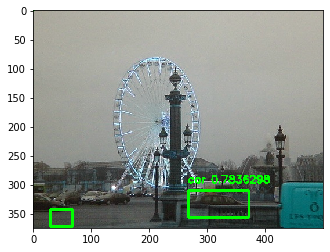

In [53]:
#model.load_weights('yolo_400.h5')
#_IOU(true_lb[LABELS[11]],boxes[0][:4])
(xmin,ymin,xmax,ymax)=true_lb['car']
cv2.rectangle(image, (int(xmin),int(ymin)), (int(xmax),int(ymax)), (0,255,0), 3)
plt.imshow(image)

In [54]:
lbls

[{'name': 'car',
  'xmin': 230.464,
  'ymin': 349.44,
  'xmax': 306.176,
  'ymax': 373.8453333333333},
 {'name': 'car',
  'xmin': 0.832,
  'ymin': 349.44,
  'xmax': 46.592,
  'ymax': 388.26666666666665},
 {'name': 'car',
  'xmin': 91.52,
  'ymin': 345.00266666666664,
  'xmax': 142.272,
  'ymax': 374.95466666666664},
 {'name': 'car',
  'xmin': 69.88799999999999,
  'ymin': 346.11199999999997,
  'xmax': 99.83999999999999,
  'ymax': 371.62666666666667},
 {'name': 'car',
  'xmin': 30.784,
  'ymin': 343.8933333333333,
  'xmax': 68.224,
  'ymax': 372.736}]

In [55]:
true_lb['car']

(30.784, 343.8933333333333, 68.224, 372.736)

In [14]:
def _IOU(bboxes1, bboxes2):
        import pdb;pdb.set_trace()
        x1_min, y1_min, x1_max, y1_max = list(bboxes1)
        x2_min, y2_min, x2_max, y2_max = list(bboxes2)
        xA = np.maximum(x1_min, x2_min)
        yA = np.maximum(y1_min, y2_min)
        xB = np.minimum(x1_max, x2_max)
        yB = np.minimum(y1_max, y2_max)
        interArea = np.maximum((xB - xA ), 0) * np.maximum((yB - yA ), 0)
        boxAArea = (x1_max - x1_min ) * (y1_max - y1_min )
        boxBArea = (x2_max - x2_min ) * (y2_max - y2_min )
        iou = interArea / (boxAArea + boxBArea - interArea)
        return iou

In [ ]:
model.save('yolo_400_.h5')

### Extra Debug

In [ ]:
GRID_W=7
GRID_H=7
BATCH_SIZE=10
cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
cell_y = tf.transpose(cell_x, (0,2,1,3,4))
cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])

#pred_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
#pred_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
sess=tf.Session()
x,y,grid=sess.run([cell_x,cell_y,cell_grid])

In [ ]:
x.shape,y.shape,grid.shape

In [ ]:
z=np.concatenate([x,y],-1)
z.shape

In [ ]:
y_true=np.ones((7,7,10))
ob_mask= tf.expand_dims(y_true[..., 4], axis=-1)
sess=tf.Session()
_mask=sess.run(ob_mask)
_mask.shape,y_true[..., 4].shape

In [ ]:
import numpy as np
import tensorflow as tf
label=np.ones((7,7,15))
label[...,14]=5
true_box=np.argmax(label[...,10:],-1)

In [ ]:
wts=np.ones((10))
wts[3:7]=9
res=tf.gather(wts,true_box)
sess=tf.Session()
ret=sess.run(res)
ret

In [ ]:
ret.shape

In [ ]:
label[...,4:].shape

In [ ]:
label[...,5:].shape

In [ ]:
label[...,5:].shape

### Extra functions

In [ ]:
import csv

def read_data(dataset):
  f=open(dataset+'/label.csv')
  file=csv.reader(f,delimiter=',')
  data=[]
  i=0
  sc=416.0
  for line in file:
      dt=line
      H=dt[0]
      W=dt[1]
      xmin=(float(dt[2]))/sc
      ymin=(float(dt[3]))/sc
      xmax=(float(dt[4]))/sc
      ymax=(float(dt[5]))/sc

      output={
          'filename':dataset+'/images/'+str(i)+'.jpg',
          'height':H,
          'width':W,
          'object':[{'name':'None',
          'xmin':xmin*IMAGE_W,
          'ymin':ymin*IMAGE_H,
          'xmax':xmax*IMAGE_W,
          'ymax':ymax*IMAGE_H}]
          }

      data.append(output)
      i=i+1
  return data
